## 📦 Setup

Shape: (20, 38)

Column types:
 ticker                            object
6m_return                        float64
12m_return                       float64
volatility                       float64
max_drawdown_1y                  float64
sector_relative_6m               float64
sma_50_200_delta                 float64
net_debt_to_ebitda               float64
ebit_interest_cover              float64
ebit_interest_cover_capped          bool
eps_cagr_3y                      float64
fcf_cagr_3y                      float64
dividend_yield                   float64
dividend_cagr_3y                 float64
dividend_cagr_5y                 float64
yield_vs_5y_median               float64
pe_ratio                         float64
pfcf_ratio                       float64
payout_ratio                     float64
sector_materials                   int64
sector_basic_materials             int64
sector_healthcare                  int64
sector_consumer_cyclical           int64
sector_real_estate       

/workspaces/dvmax/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


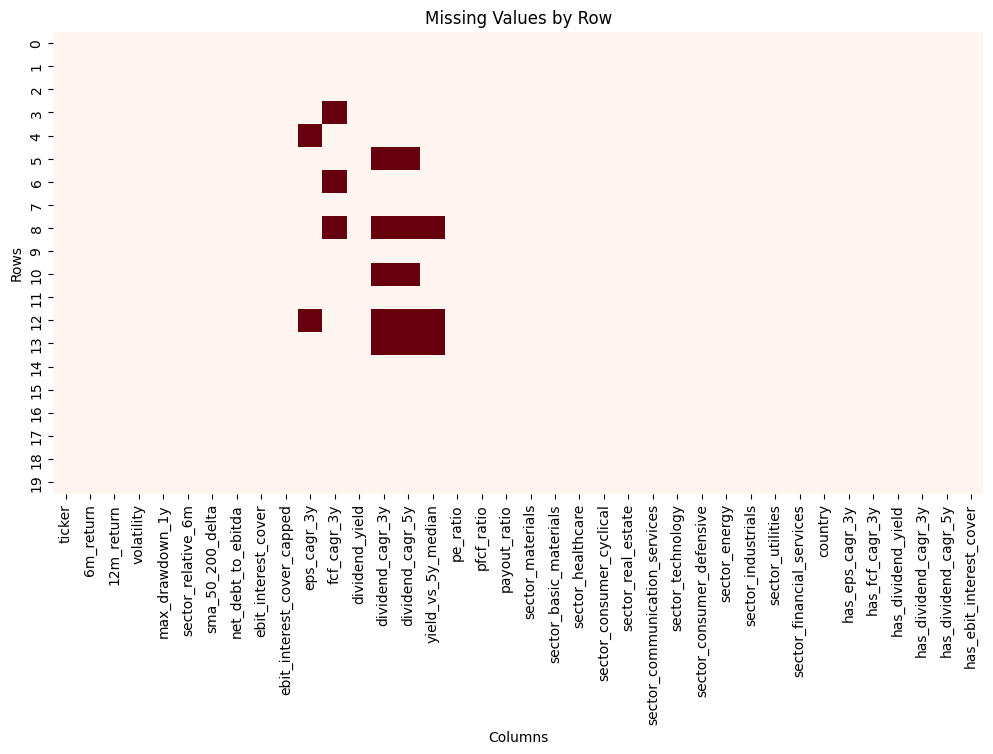

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

# 📁 Load the merged Parquet
parquet_path = "features_parquet/22-05-2025/features_all.parquet"
df = pl.read_parquet(parquet_path)

# 🔁 Convert to pandas for viz (optional)
pdf = df.to_pandas()

# 👀 Preview data
pdf.head()

# Basic info
print("Shape:", pdf.shape)
print("\nColumn types:\n", pdf.dtypes)
pdf.describe(include='all').T

## 🧼 Null Values Heatmap

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(pdf.isnull(), cbar=False, cmap="Reds")
plt.title("Missing Values by Row")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

## ✂️ Grouped Feature Sets for Visualization

In [ ]:
growth_metrics = ["eps_cagr_3y", "fcf_cagr_3y", "dividend_cagr_3y", "dividend_cagr_5y"]
return_volatility_metrics = ["6m_return", "12m_return", "sector_relative_6m", "volatility", "max_drawdown_1y"]
fundamentals_metrics = ["pe_ratio", "pfcf_ratio", "payout_ratio", "dividend_yield", "yield_vs_5y_median",
                        "net_debt_to_ebitda", "ebit_interest_cover", "ebit_interest_cover_capped"]

metric_groups = {
    "Growth": growth_metrics,
    "Returns & Volatility": return_volatility_metrics,
    "Fundamentals": fundamentals_metrics,
}

# 🔍 Helper Function to Clean Data
def clean_numeric(df, cols):
    sub_df = df[cols].replace([np.inf, -np.inf], np.nan).dropna()
    return sub_df

## 📊 Histograms by Group

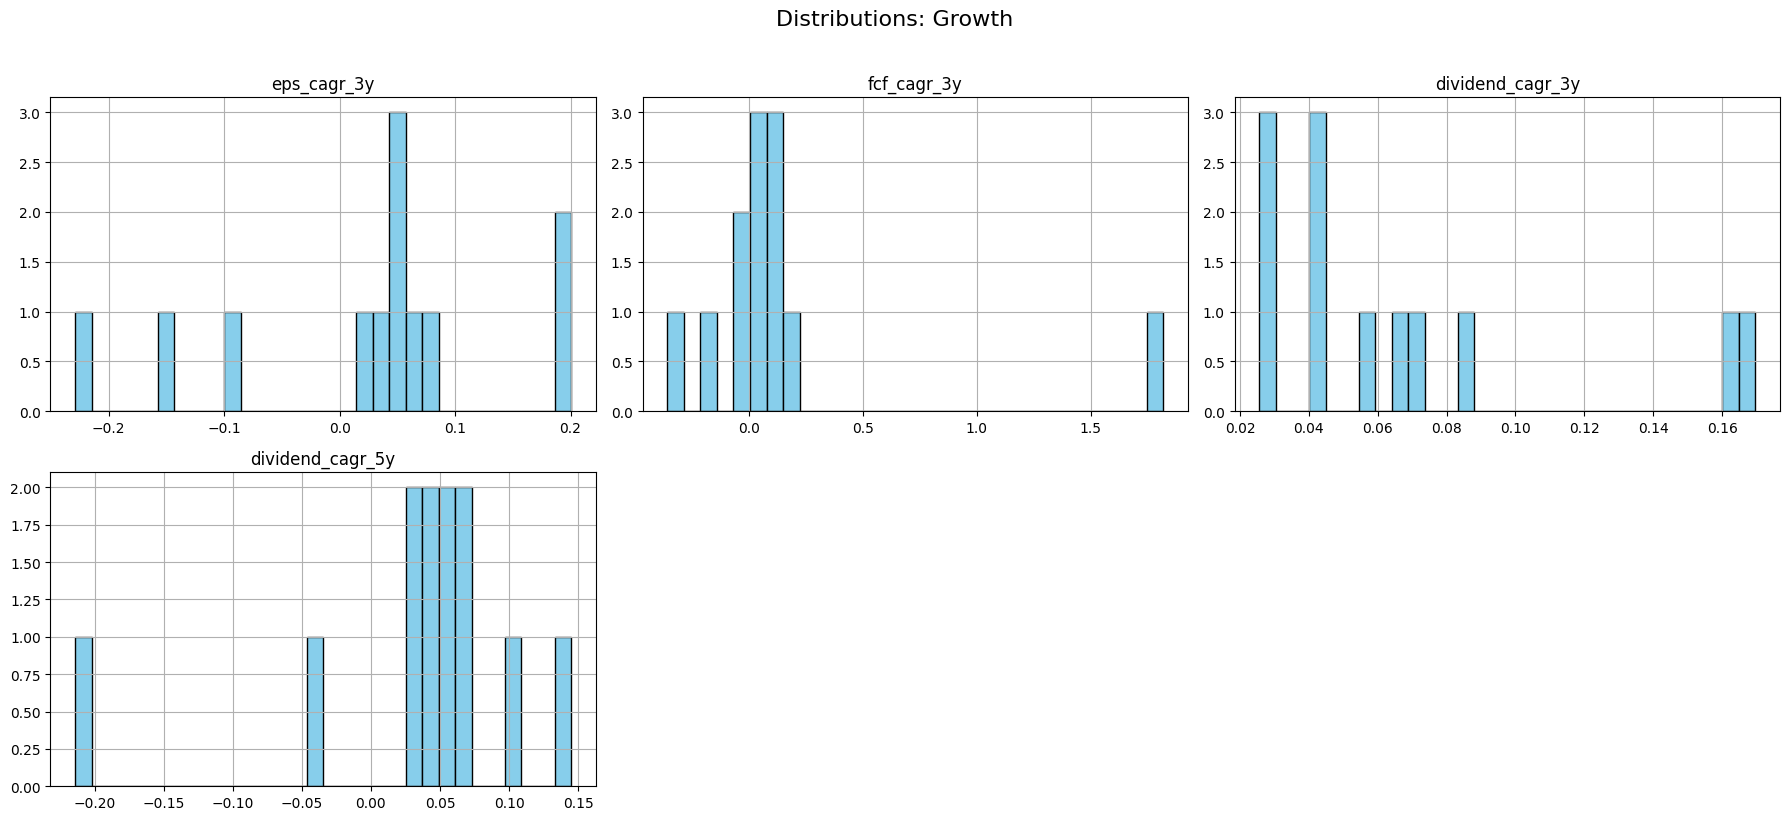

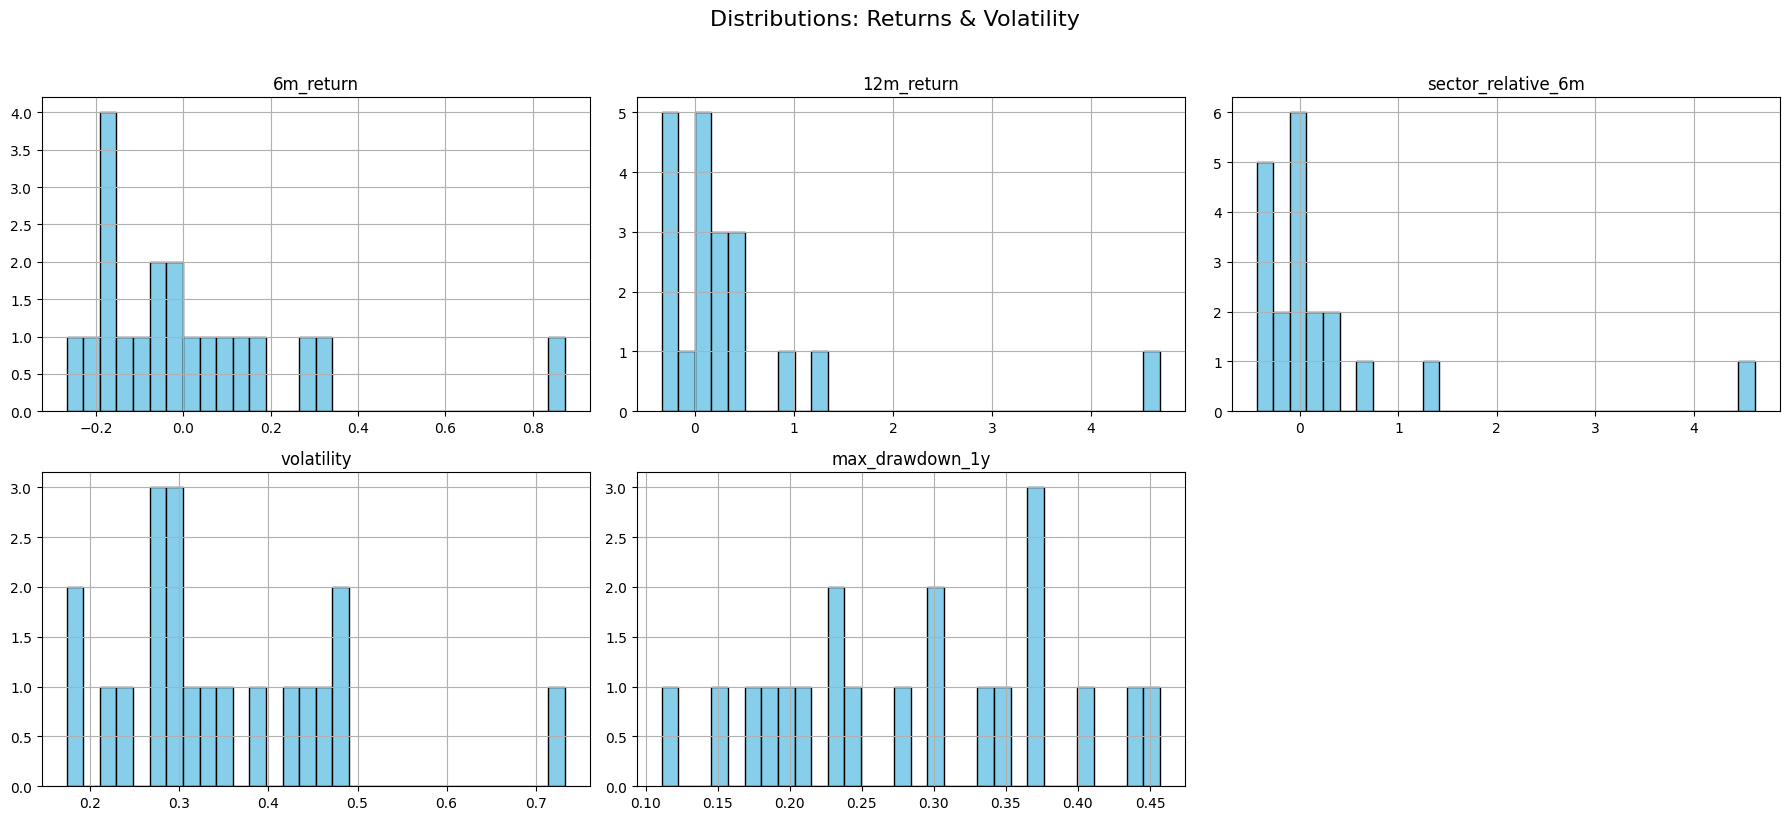

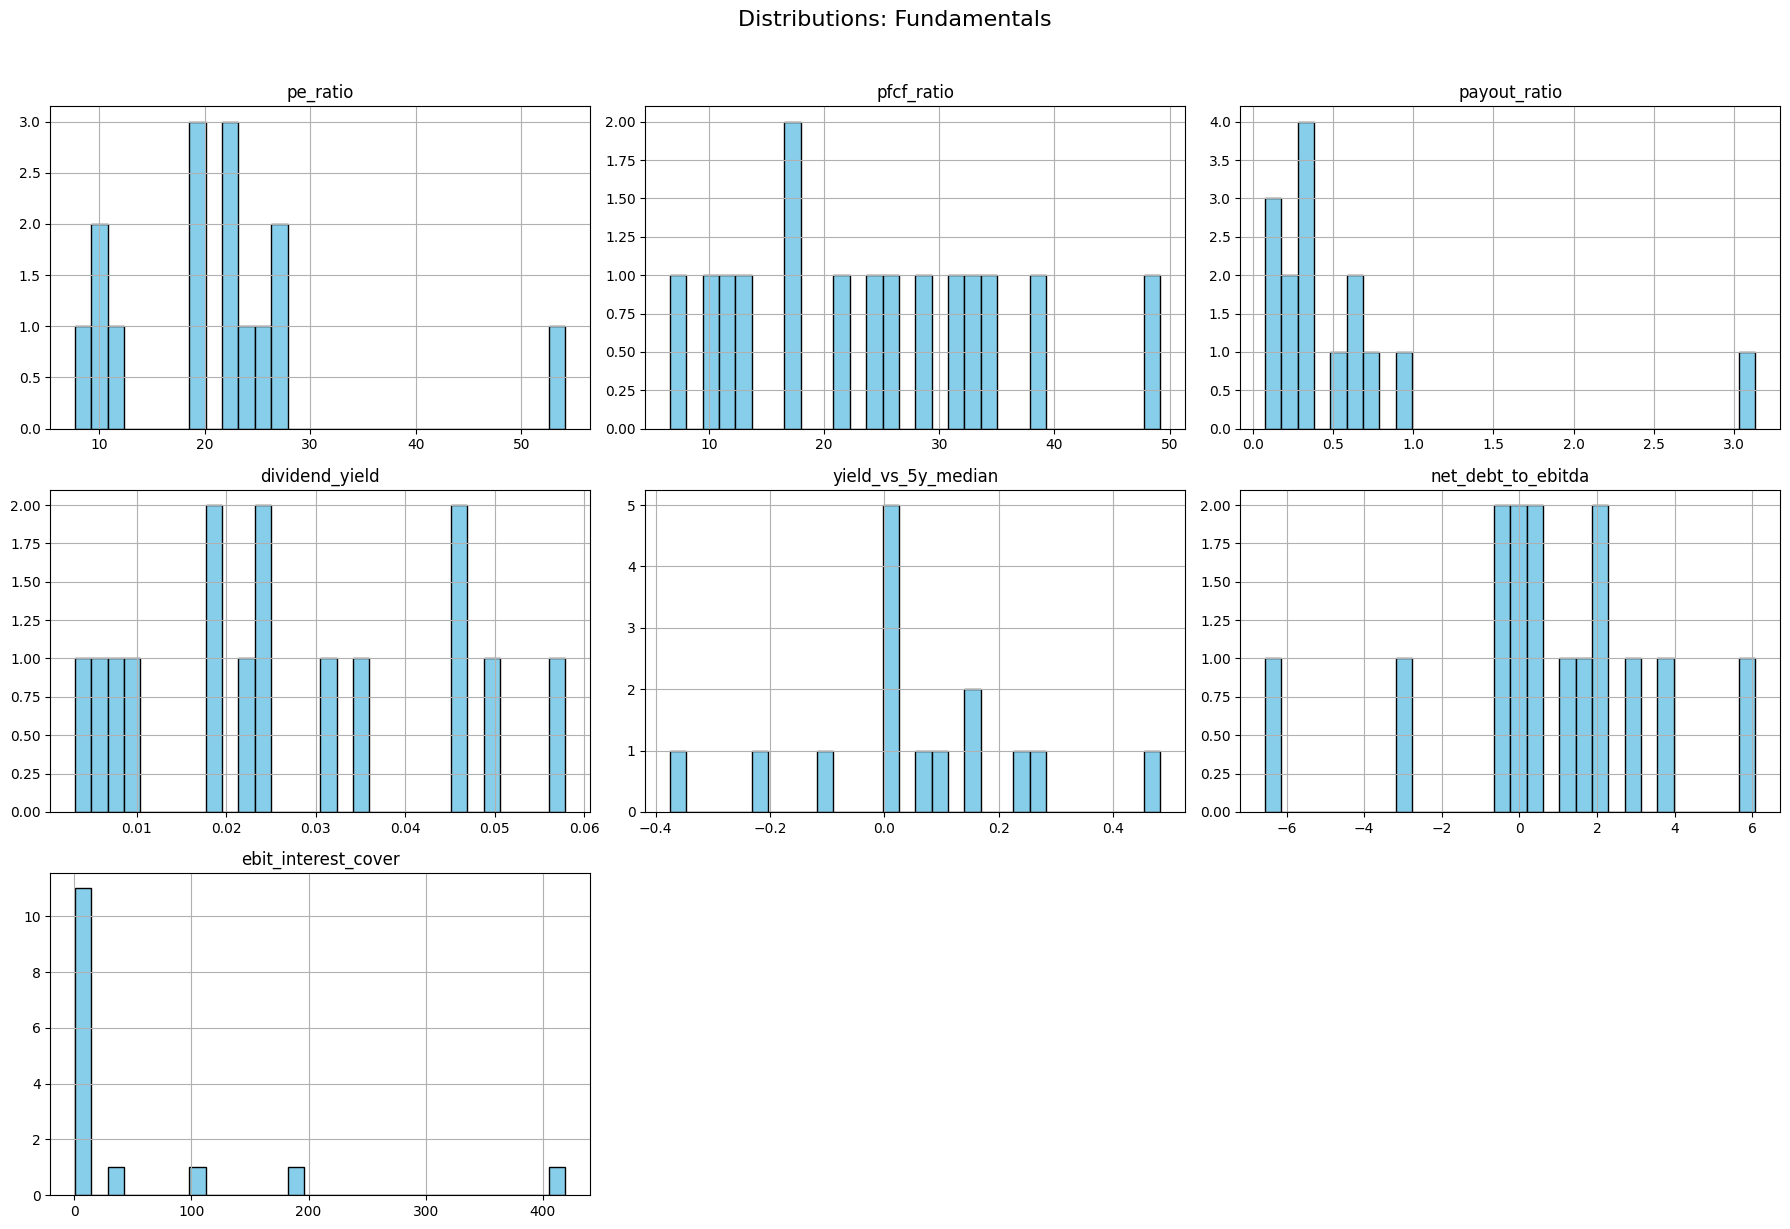

In [ ]:
for group_name, cols in metric_groups.items():
    sub_df = clean_numeric(pdf, cols)
    n = len(cols)
    n_cols = min(n, 3)
    n_rows = math.ceil(n / n_cols)
    sub_df.hist(
        figsize=(6 * n_cols, 4 * n_rows), bins=30, edgecolor='black', color='skyblue',
        layout=(n_rows, n_cols)
    )
    plt.suptitle(f"Distributions: {group_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

## 📈 Boxplots by Group

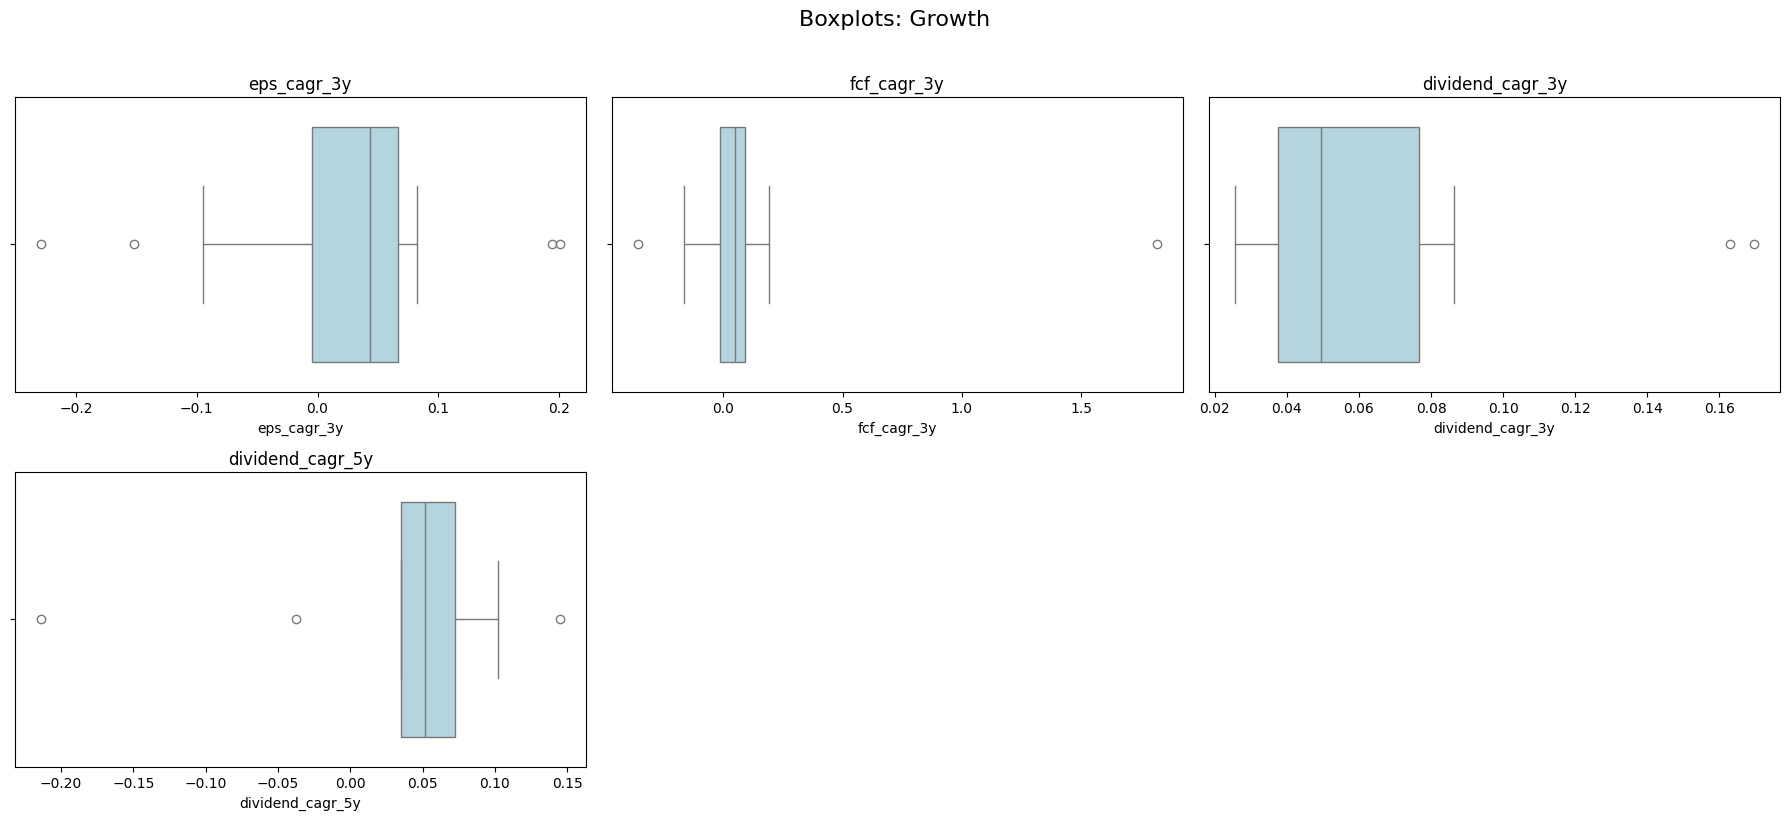

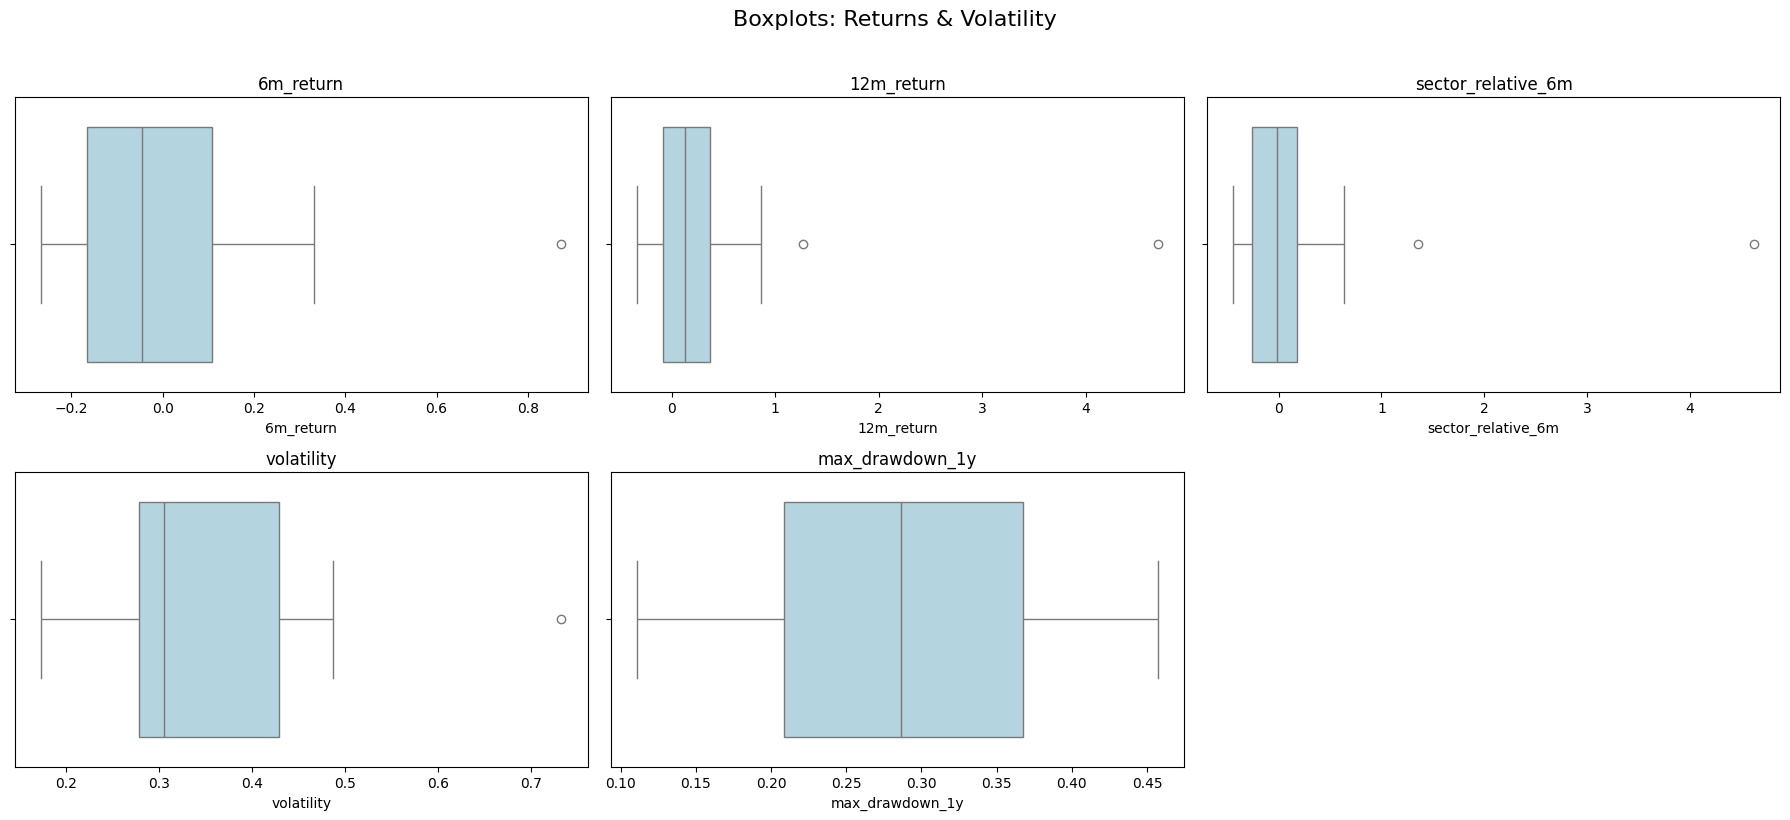

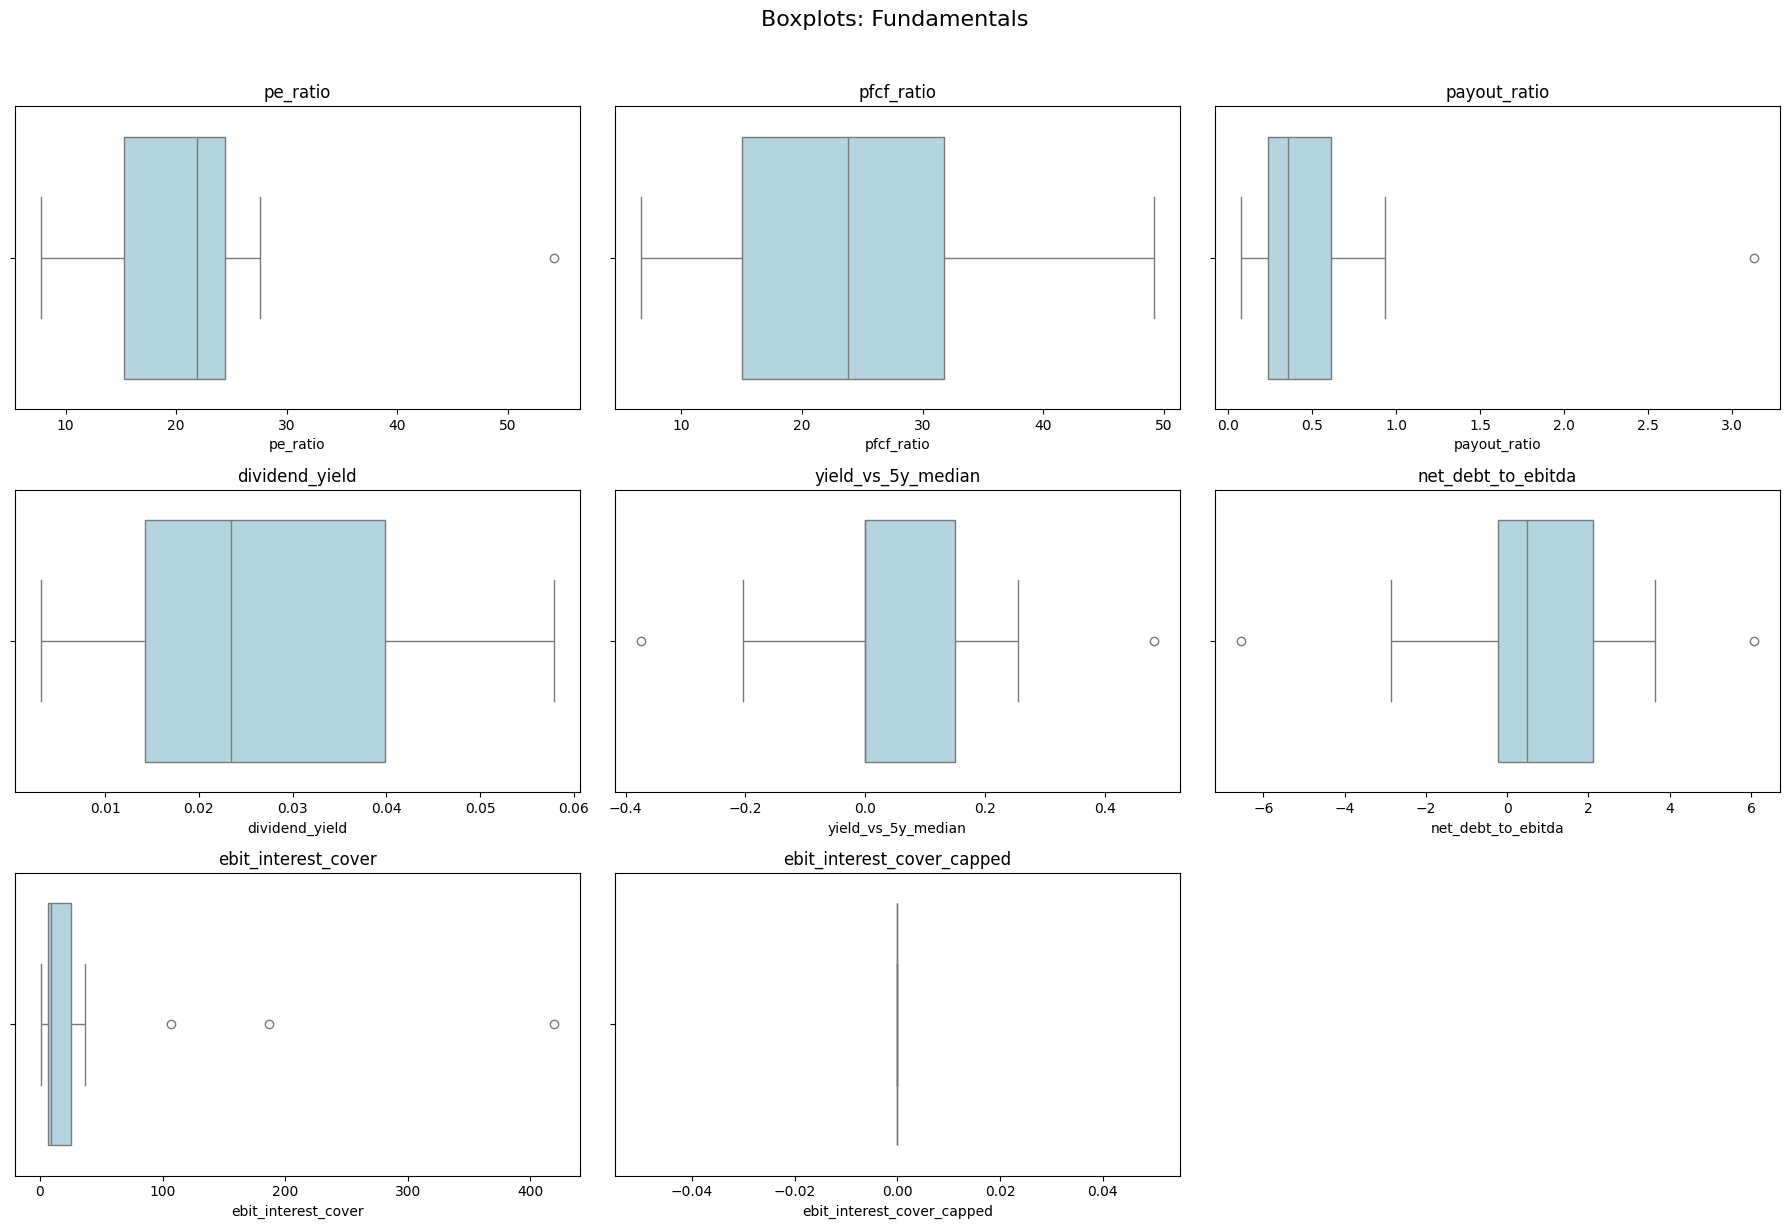

In [ ]:
for group_name, cols in metric_groups.items():
    sub_df = clean_numeric(pdf, cols)
    n = len(cols)
    n_cols = min(n, 3)
    n_rows = math.ceil(n / n_cols)
    plt.figure(figsize=(6 * n_cols, 4 * n_rows))
    for i, col in enumerate(cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(x=sub_df[col], color="lightblue")
        plt.title(col)
    plt.suptitle(f"Boxplots: {group_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


## 📌 Correlation Heatmaps by Group


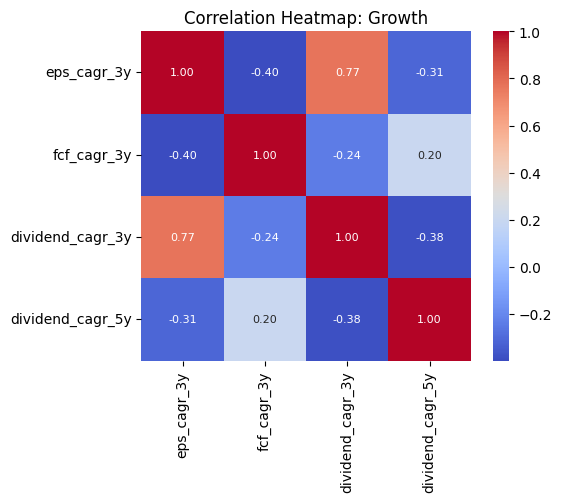

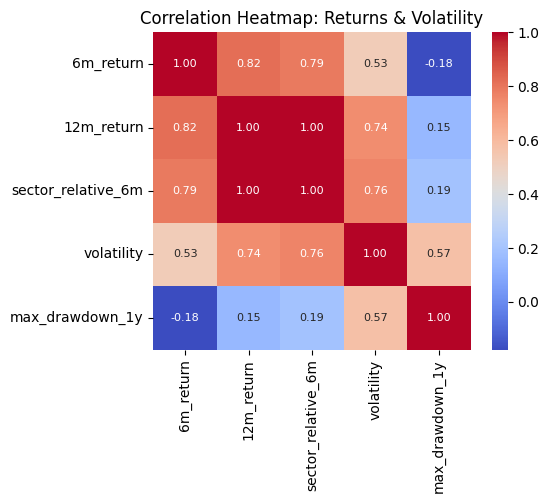

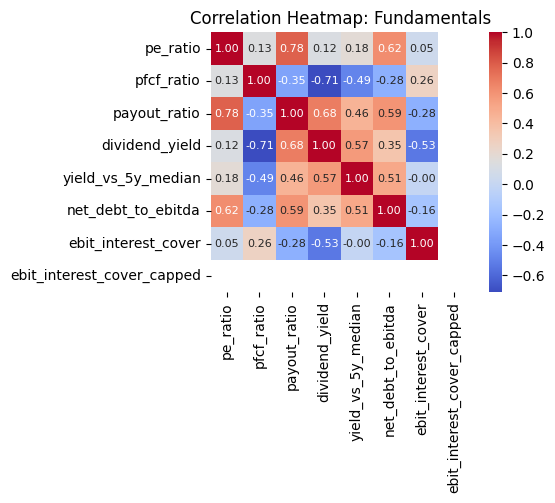

In [ ]:
for group_name, cols in metric_groups.items():
    sub_df = clean_numeric(pdf, cols)
    if sub_df.shape[1] > 1:
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            sub_df.corr(), annot=True, fmt=".2f", cmap="coolwarm",
            square=True, cbar=True, annot_kws={"size": 8}
        )
        plt.title(f"Correlation Heatmap: {group_name}")
        plt.tight_layout()
        plt.show()

## 🕸 Radar Chart

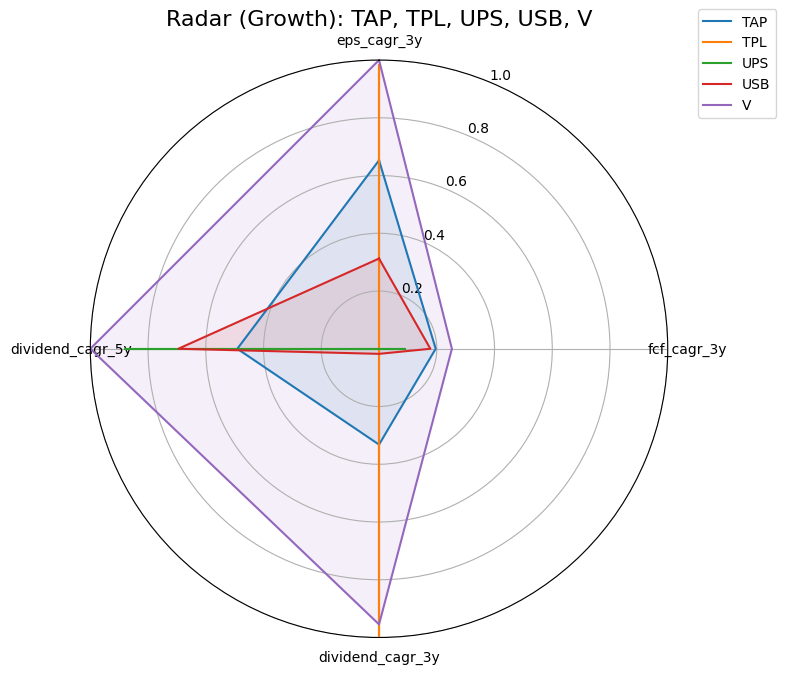

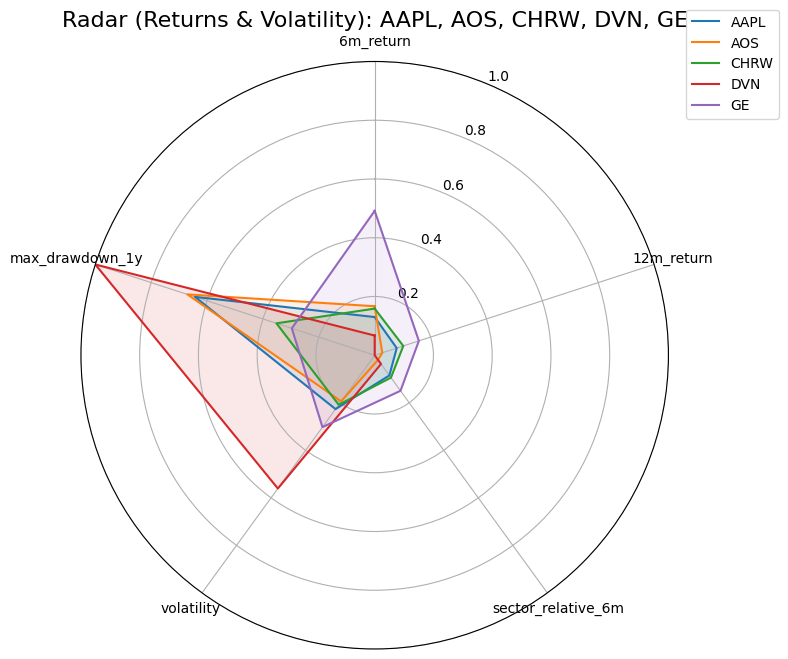

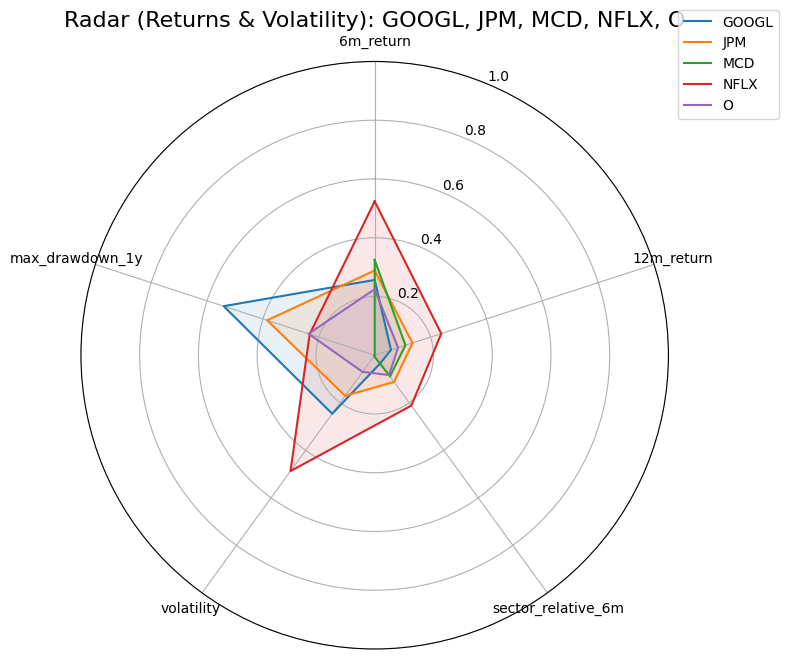

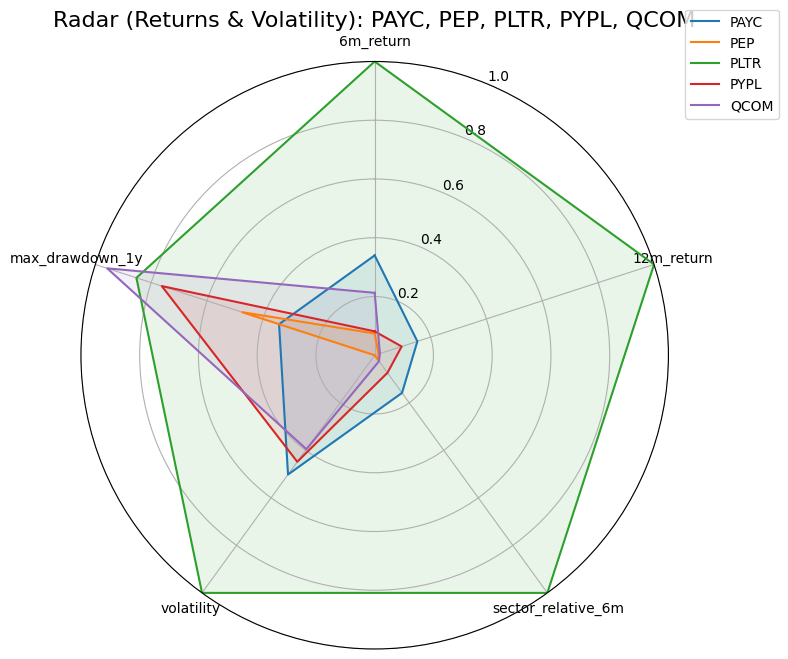

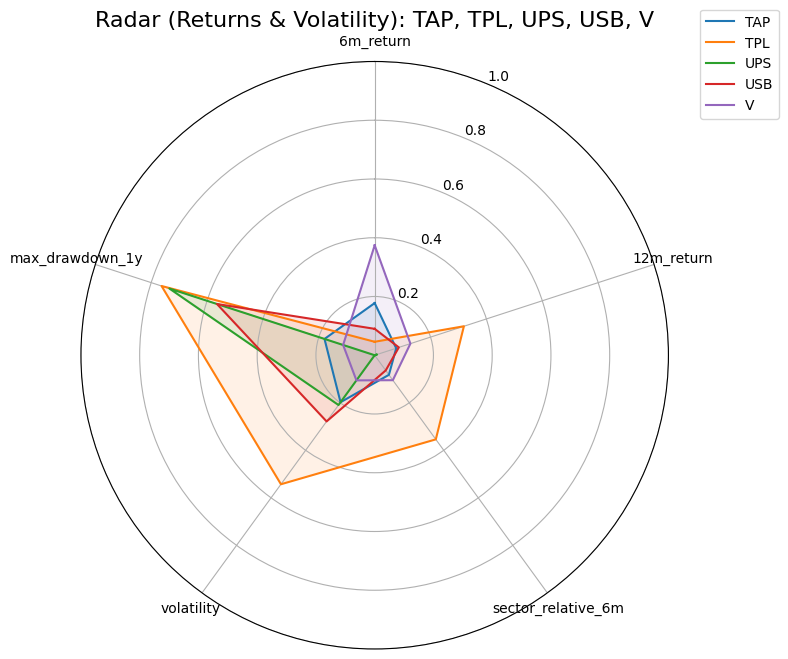

In [ ]:
def plot_radar(df, tickers, features, title="Radar Chart"):
    df = df.set_index("ticker")
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features)
    if not all(t in df.index for t in tickers):
        return

    df_norm = (df[features] - df[features].min()) / (df[features].max() - df[features].min())
    df_norm = df_norm.clip(0, 1).loc[tickers]

    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for ticker in df_norm.index:
        values = df_norm.loc[ticker].tolist() + [df_norm.loc[ticker].tolist()[0]]
        ax.plot(angles, values, label=ticker)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), features)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

# 📍 Plot radar for each group
unique_tickers = pdf["ticker"].dropna().tolist()
jump = 5

for group_name, features in metric_groups.items():
    for i in range(0, len(unique_tickers), jump):
        batch = unique_tickers[i:i + jump]
        plot_radar(pdf.copy(), batch, features, title=f"Radar ({group_name}): {', '.join(batch)}")

## 🔢 Raw Feature Plot per Ticker

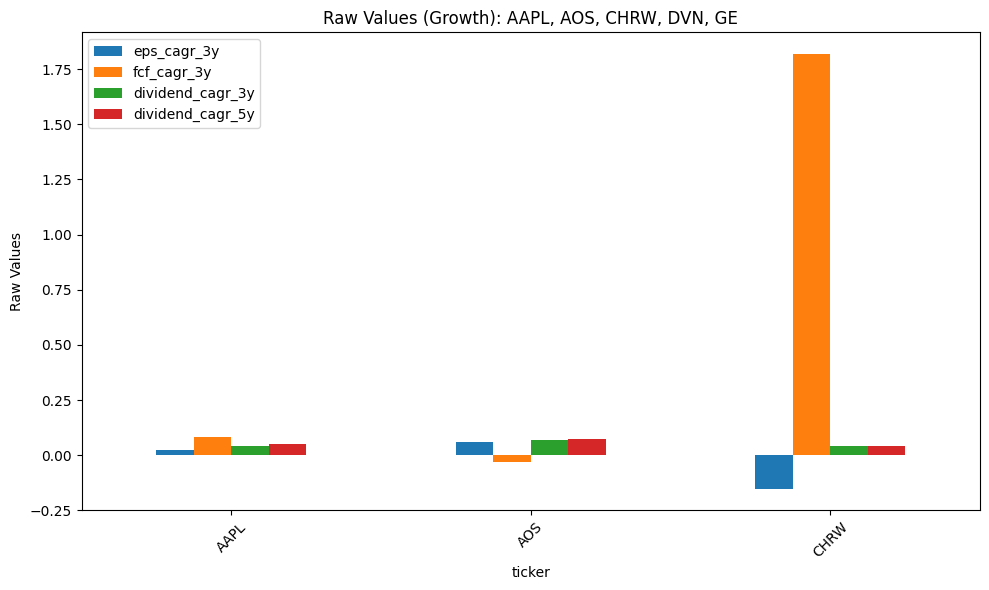

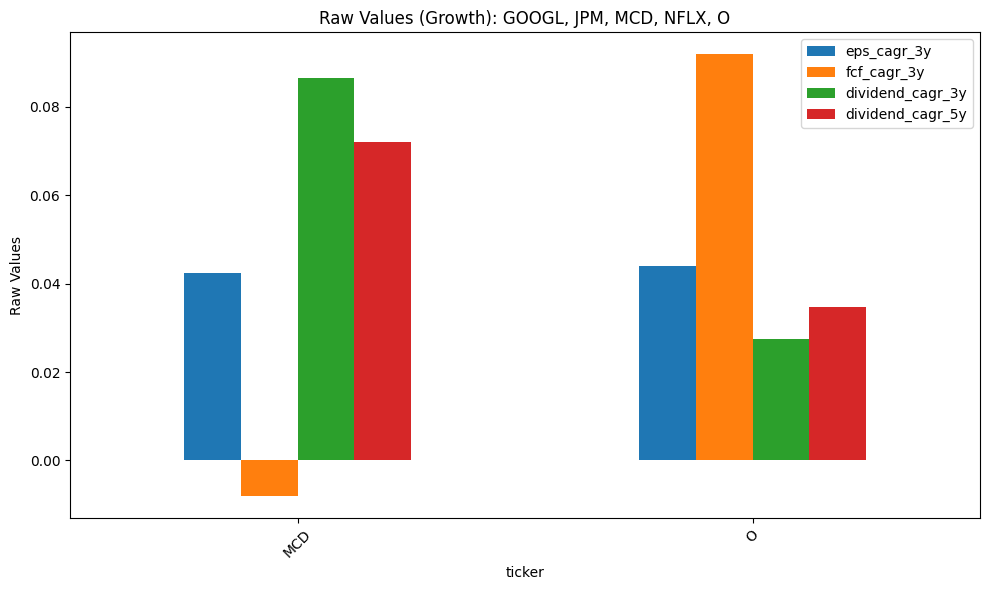

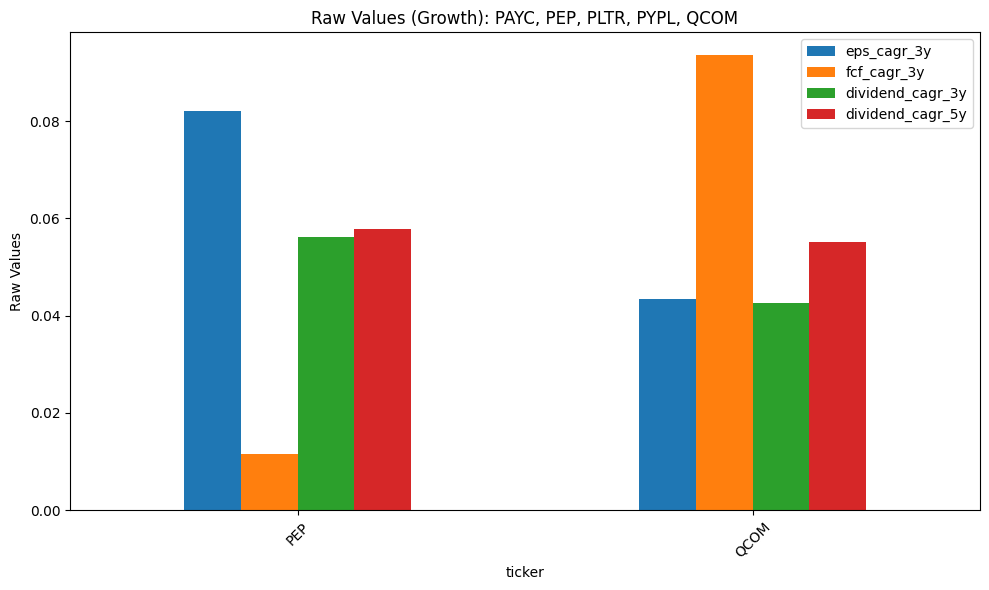

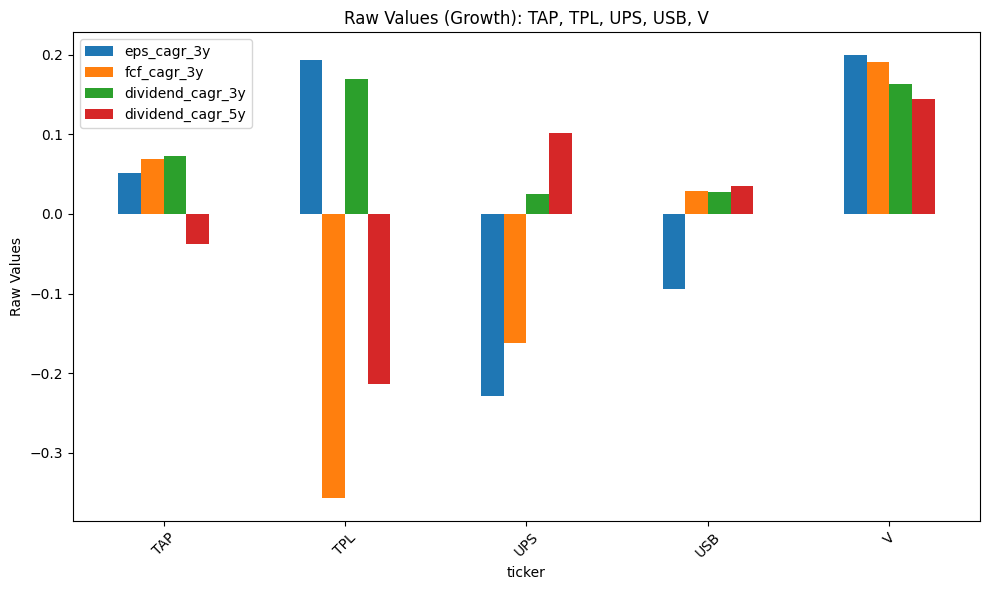

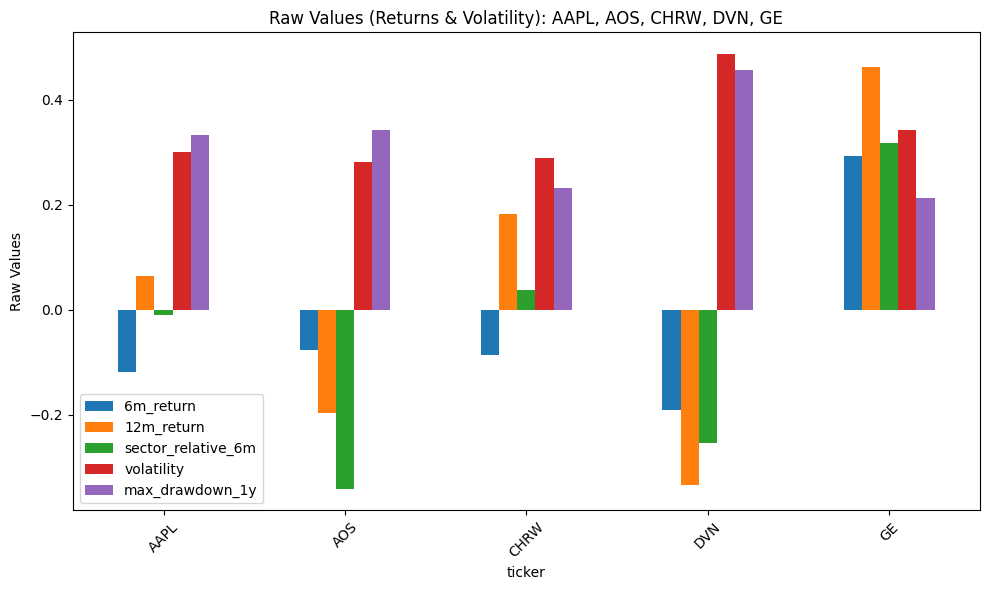

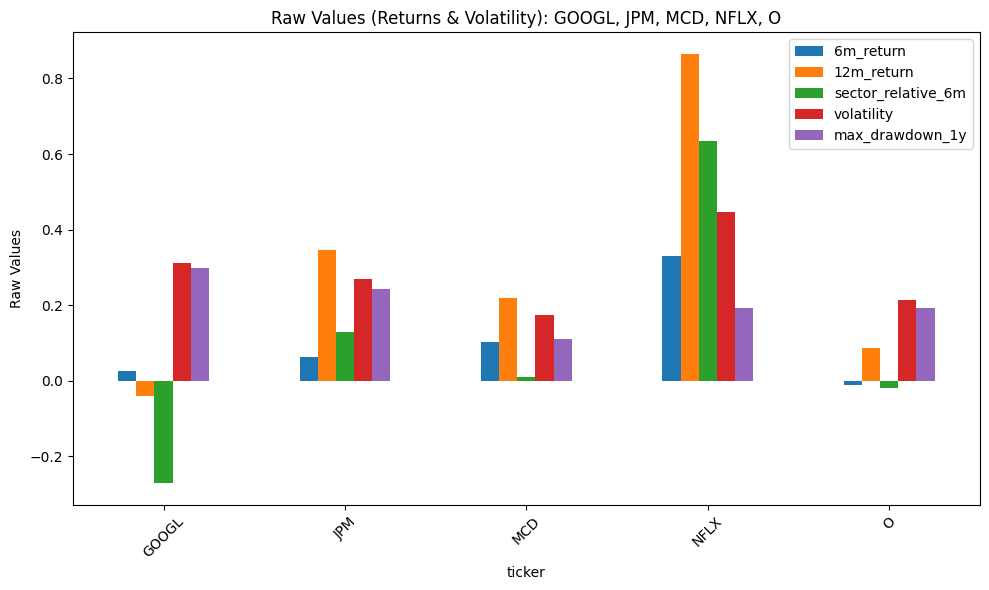

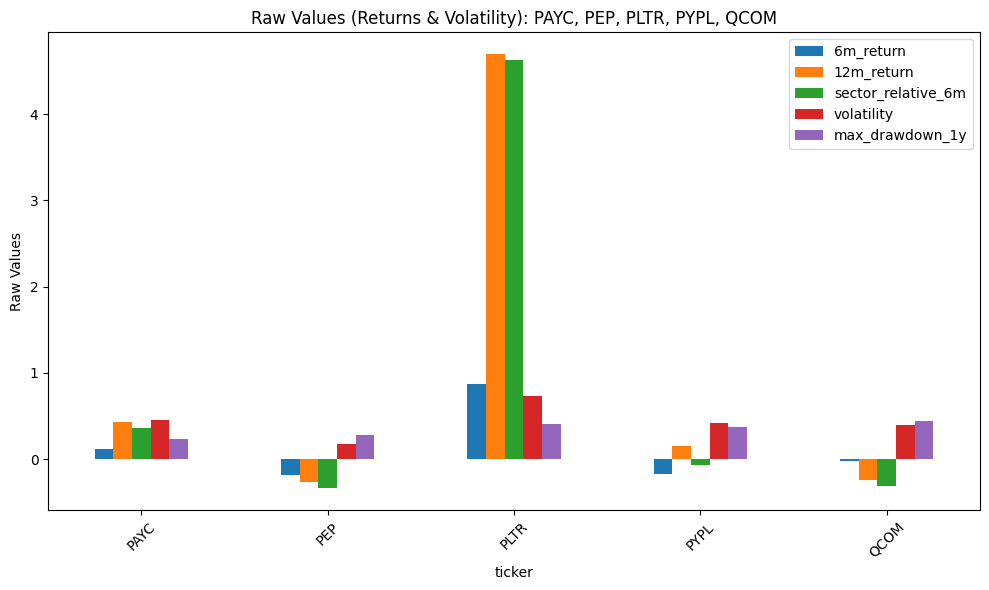

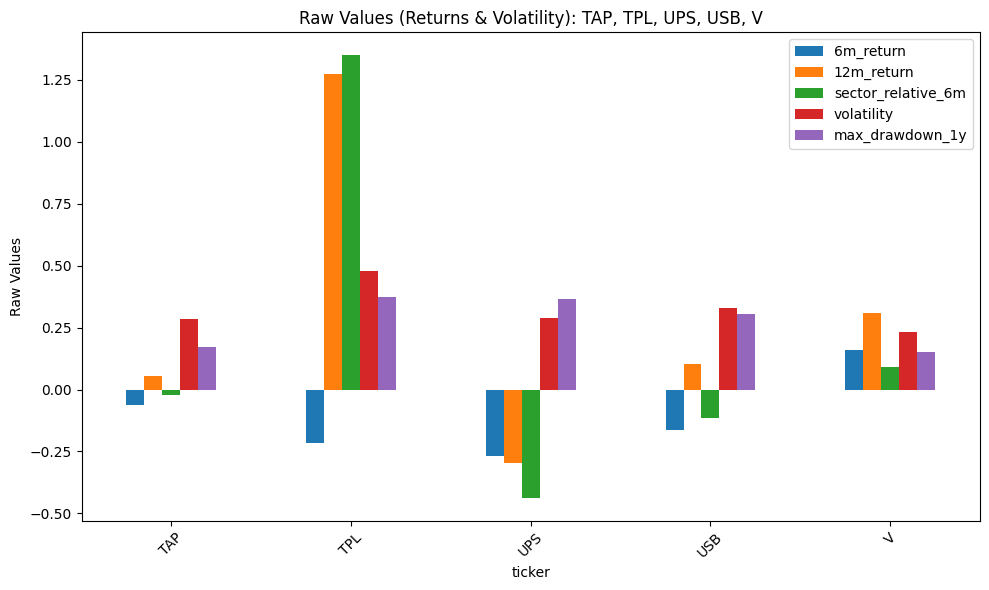

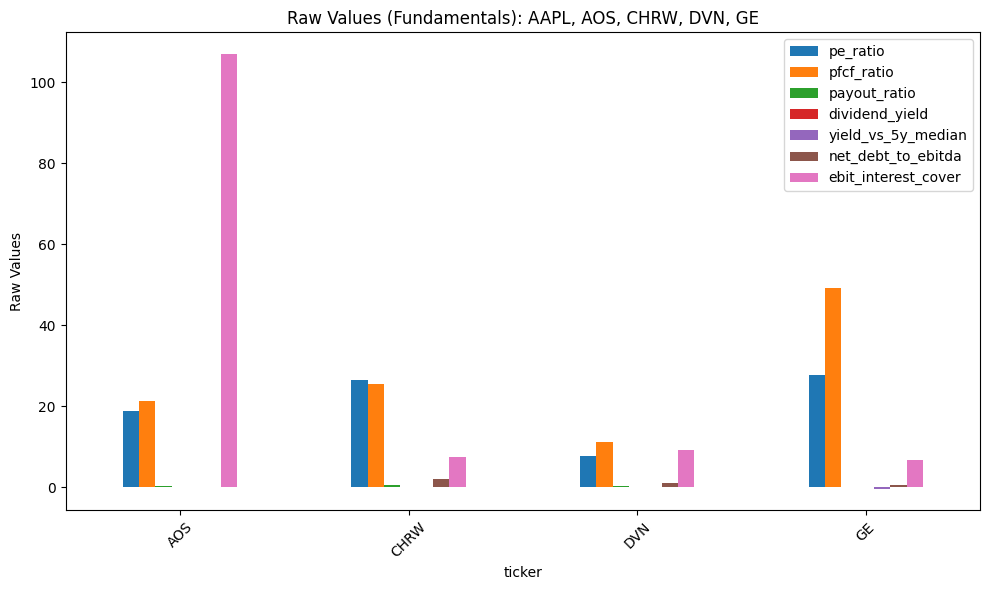

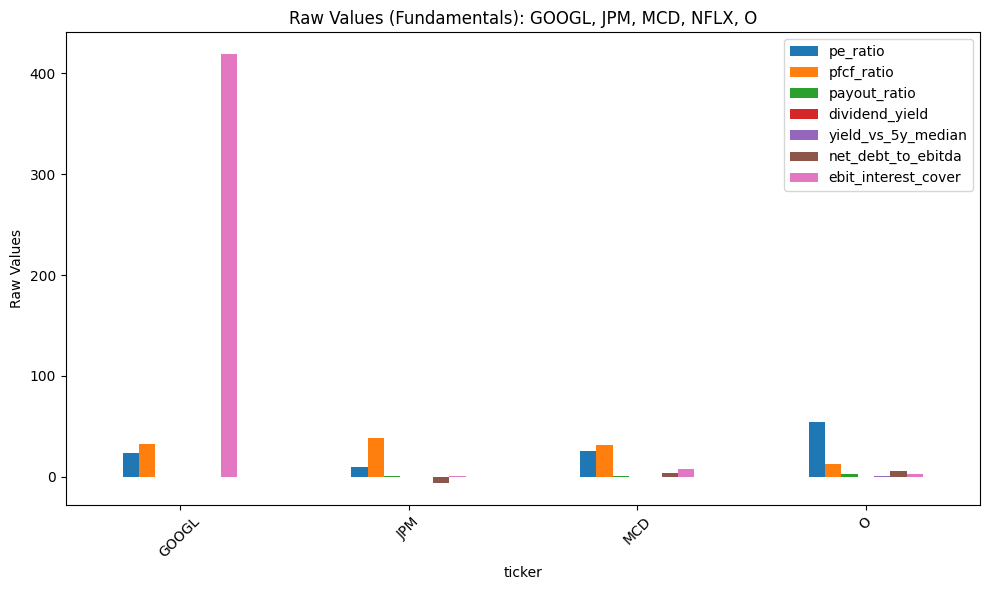

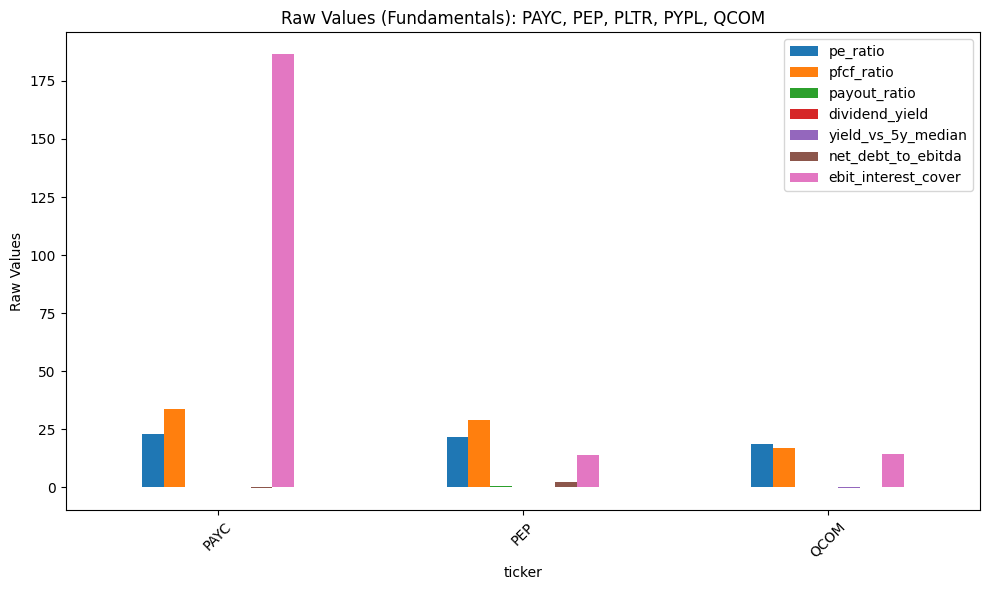

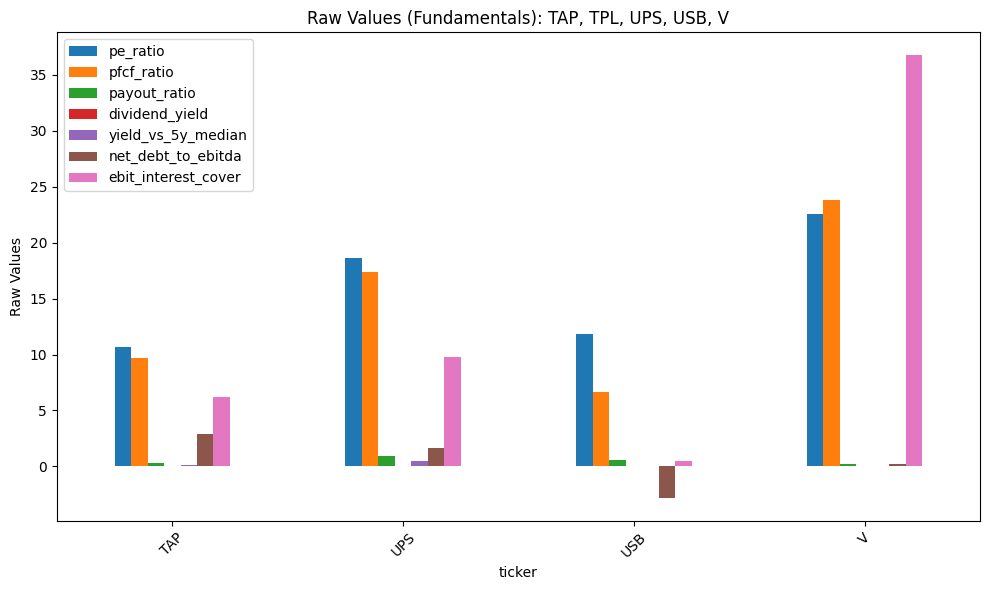

In [ ]:

def plot_raw_bars(df, tickers, features, title="Raw Values"):
    sub_df = df[df["ticker"].isin(tickers)][["ticker"] + features].replace([np.inf, -np.inf], np.nan).dropna()
    sub_df.set_index("ticker", inplace=True)
    ax = sub_df.plot(kind="bar", figsize=(10, 6))
    plt.title(title)
    plt.ylabel("Raw Values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot raw values by group
for group_name, features in metric_groups.items():
    for i in range(0, len(unique_tickers), jump):
        batch = unique_tickers[i:i + jump]
        plot_raw_bars(pdf.copy(), batch, features, title=f"Raw Values ({group_name}): {', '.join(batch)}")
